<a href="https://colab.research.google.com/github/kanaifu/KOMB-scripts/blob/master/ELEC_478_Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELEC 478 Homework 2

### Problem 1
Cross-Validation & Interpretation. For this problem, you can consider binary classification of the digits 3 and 8.

(i) Code up K-fold cross-validation (from scratch) and use your function to tune hyper-parameters for sparse logistic regression and linear SVMs. Plot the cross-validation error curve along with the training and test error. Compare which hyperparameters your cross-validation procedure selects to those from built in functions. Reflect on your results. Hint: You may consider using the logistic log-likelihood or binomial deviance loss instead of the miss-classification error for this problem.

(ii) Interpret your sparse logistic regression and linear SVM model selected via cross-validation. Which features are most important? Which observations are particularly difficult or easy to classify? Visualize and discuss your results.
### Load Data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import mnist
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[(y_train == 3) | (y_train == 8)] # choose data only with 3s and 8s for this problem
y_train = y_train[(y_train == 3) | (y_train == 8)]
X_test = X_test[(y_test == 3) | (y_test == 8)]
y_test = y_test[(y_test == 3) | (y_test == 8)]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Convert the labels to binary: 0 for 3, 1 for 8
y_train = (y_train == 8).astype(int)
y_test = (y_test == 8).astype(int)

# Reshape the features to be one-dimensional vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape, X_test.shape)


(11982, 28, 28) (11982,) (1984, 28, 28) (1984,)
(11982, 784) (1984, 784)


Cross-validation function from scratch:

In [4]:
def k_fold_cv(model, param_name, param_range, X, y, K):
    val_errors = {}
    train_errors = []
    test_errors = []

    np.random.seed(420)
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    y = y[perm]

    n = X.shape[0] // K
    folds = [(X[i*n:(i+1)*n], y[i*n:(i+1)*n]) for i in range(K)] # split data into K chunks

    for param in param_range:
        # Set the hyperparameter value for the model
        setattr(model, param_name, param)
        fold_errors = []

        for i in range(K):
            X_val, y_val = folds[i]
            X_train = np.concatenate([folds[j][0] for j in range(K) if j != i])
            y_train = np.concatenate([folds[j][1] for j in range(K) if j != i])

            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            val_error = log_loss(y_val, y_pred)
            fold_errors.append(val_error)

        avg_val_error = np.mean(fold_errors)

        val_errors[param] = avg_val_error

        model.fit(X, y)
        y_pred_train = model.predict(X)
        train_error = log_loss(y, y_pred_train)
        train_errors.append(train_error)
        y_pred_test = model.predict(X_test)
        test_error = log_loss(y_test, y_pred_test)
        test_errors.append(test_error)

    # Return the dictionary of validation errors, and the lists of training and test errors
    return val_errors, train_errors, test_errors

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


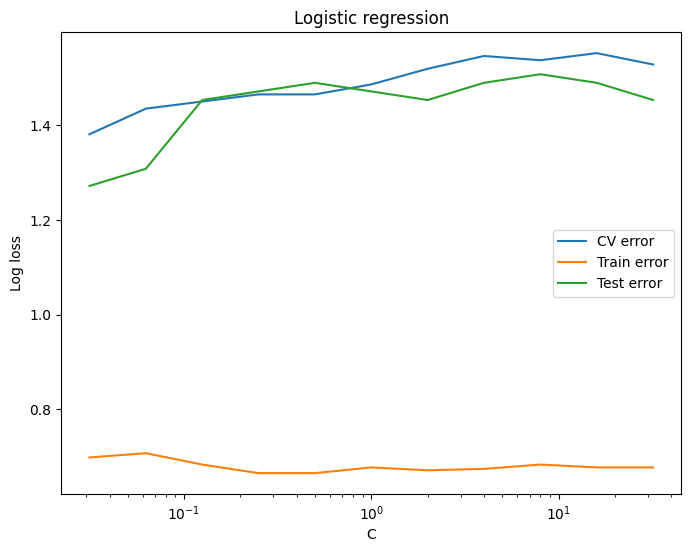

The optimal C value for logistic regression based on cross-validation is 0.031
The optimal C value for logistic regression based on built-in function is 0.031


In [5]:
C_range = np.logspace(-5, 5, num=11, base=2) # hyperparameter range

log_reg = LogisticRegression(penalty="l1", solver="liblinear")

# Perform cv for logistic regression
log_reg_val_errors, log_reg_train_errors, log_reg_test_errors = k_fold_cv(log_reg, "C", C_range, X_train, y_train, 5)

# Plot the cross-validation error curve for logistic regression
plt.figure(figsize=(8, 6))
plt.plot(C_range, list(log_reg_val_errors.values()), label="CV error")
plt.plot(C_range, log_reg_train_errors, label="Train error")
plt.plot(C_range, log_reg_test_errors, label="Test error")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Log loss")
plt.title("Logistic regression")
plt.legend()
plt.show()

# Find the optimal C value for logistic regression
log_reg_opt_C = min(log_reg_val_errors, key=log_reg_val_errors.get)
print(f"The optimal C value for logistic regression based on cross-validation is {log_reg_opt_C:.3f}")

# Compare with the built-in function from sklearn
log_reg_cv = LogisticRegressionCV(penalty="l1", solver="liblinear", Cs=C_range).fit(X_train, y_train)
print(f"The optimal C value for logistic regression based on built-in function is {log_reg_cv.C_[0]:.3f}")



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

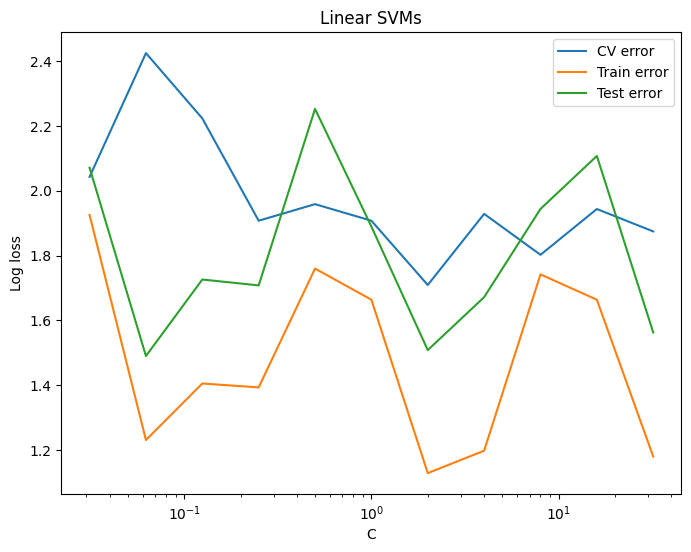

The optimal C value for linear SVMs based on cross-validation is 2.000
The optimal C value for linear SVMs based on built-in function is 2.000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
C_range = np.logspace(-5, 5, num=11, base=2) # hyperparameter range

lin_svm = LinearSVC(loss="hinge")

# Perform cv for linear SVM
lin_svm_val_errors, lin_svm_train_errors, lin_svm_test_errors = k_fold_cv(lin_svm, "C", C_range, X_train, y_train, 5)


# Plot the cross-validation error curve for linear SVMs
plt.figure(figsize=(8, 6))
plt.plot(C_range, list(lin_svm_val_errors.values()), label="CV error")
plt.plot(C_range, lin_svm_train_errors, label="Train error")
plt.plot(C_range, lin_svm_test_errors, label="Test error")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Log loss")
plt.title("Linear SVMs")
plt.legend()
plt.show()

# Find optimal C value for SVM
lin_svm_opt_C = min(lin_svm_val_errors, key=lin_svm_val_errors.get)
print(f"The optimal C value for linear SVMs based on cross-validation is {lin_svm_opt_C:.3f}")

# Compare with the built-in function from scikit-learn
lin_svm_cv = LinearSVC(loss="hinge", C=lin_svm_opt_C).fit(X_train, y_train)
print(f"The optimal C value for linear SVMs based on built-in function is {lin_svm_cv.C:.3f}")

Both my logistic regression and linear SVM models selected the same hyperparameter C as their corresponding built-in functions from Scikit-learn. This was C = 0.031 and C = 2, respectively. What follows from this is either that my CV implementation was so profound it performed exactly the same as the built-in methods, or that the set of hyperparameters I tuned it with was too small (11 elements, all powers of 2 between 2^{-5} and 2^5).

### Interpretation for (ii):


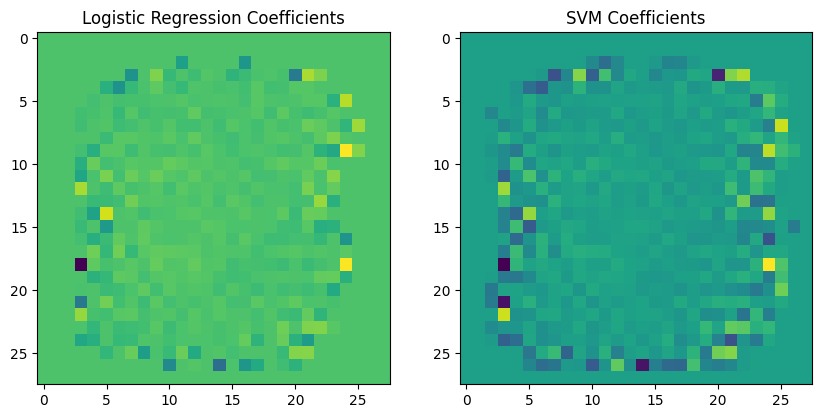

Difficult to classify observations for Logistic Regression:  [   41   108   125   141   152   202   215   228   247   291   385   395
   448   531   563   715   820   889   936   989  1018  1031  1378  1393
  1402  1409  1478  1588  1589  1608  1613  1668  1669  1703  1782  1804
  2175  2186  2206  2241  2344  2359  2371  2378  2404  2409  2462  2467
  2472  2494  2511  2574  2577  2599  2652  2716  2725  2748  2780  2801
  2852  2863  2913  2923  2926  2928  2931  2951  2995  3126  3152  3182
  3284  3326  3392  3451  3694  3773  3813  3841  3909  3918  3937  3984
  4002  4060  4074  4108  4152  4154  4180  4205  4227  4359  4382  4425
  4431  4435  4444  4627  4802  4836  4838  4884  4986  5094  5249  5332
  5403  5421  5539  5644  5792  5990  6047  6058  6084  6093  6137  6208
  6209  6248  6256  6258  6278  6291  6313  6330  6492  6613  6747  6833
  6836  6941  6973  6987  7070  7096  7198  7237  7239  7254  7255  7279
  7316  7327  7360  7413  7442  7457  7957  8058  8079  8089  8

In [7]:
# Identify important features
logistic_coef = log_reg_cv.coef_
svm_coef = lin_svm_cv.coef_

# Visualize coefficients
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(logistic_coef.reshape(28, 28), cmap='viridis')
plt.title('Logistic Regression Coefficients')

plt.subplot(1, 2, 2)
plt.imshow(svm_coef.reshape(28, 28), cmap='viridis')
plt.title('SVM Coefficients')

plt.show()

# Identify difficult or easy to classify observations
logistic_pred = log_reg_cv.predict(X_train)
svm_pred = lin_svm_cv.predict(X_train)

difficult_logistic = np.where(y_train != logistic_pred)[0]
easy_logistic = np.where(y_train == logistic_pred)[0]

difficult_svm = np.where(y_train != svm_pred)[0]
easy_svm = np.where(y_train == svm_pred)[0]

print("Difficult to classify observations for Logistic Regression: ", difficult_logistic)
print("Easy to classify observations for Logistic Regression: ", easy_logistic)

print("Difficult to classify observations for SVM: ", difficult_svm)
print("Easy to classify observations for SVM: ", easy_svm)


As we can see, the features most important are the pixels located around the outer boundary of the 8's, which are darkened in the images above. These are the only features that deviate from the standard. Interestingly, the featurs on the right boundary of the 8's (which is a boundary they share with 3's) are instead deemed as least important, which is probably the case since every image shares those pixels as active. It is likely the case that what the model implicitly does is it simply looks at the left boundary and checks if we have it present (in which case, it gives us an 8) or not (in which case we get a 3). This is obviously represented as a linear equation of whether the pixels are active or not.

# Problem 2
Multi-Class Classification. Compare and contrast the following methods for classifying all the digits:

• Logistic (Multinomial Regression).

• Naive Bayes.

• Linear Discriminant Analysis.

• Linear SVMs (one vs. one or one vs. all approach).

• Kernel SVMs with at least two different kernel types. (Which kernels did you use and why?)

For each of these, you will need to use validation or cross-validation to select any hyperparameters. Which method performs best in terms of test accuracy? Why? Provide a confusion matrix for classifying digits. Which digits are most often misclassified? Provide visualizations to help explain or interpret the results of various methods. Reflect on your results.

### Load Data:

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[(y_train == 3) | (y_train == 8) | (y_train == 5)] # choose data only with 3s and 8s for this problem
y_train = y_train[(y_train == 3) | (y_train == 8) | (y_train == 5)]
X_test = X_test[(y_test == 3) | (y_test == 8) | (y_test == 5)]
y_test = y_test[(y_test == 3) | (y_test == 8) | (y_test == 5)]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


# Reshape the features to be one-dimensional vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape, X_test.shape)

(17403, 28, 28) (17403,) (2876, 28, 28) (2876,)
(17403, 784) (2876, 784)


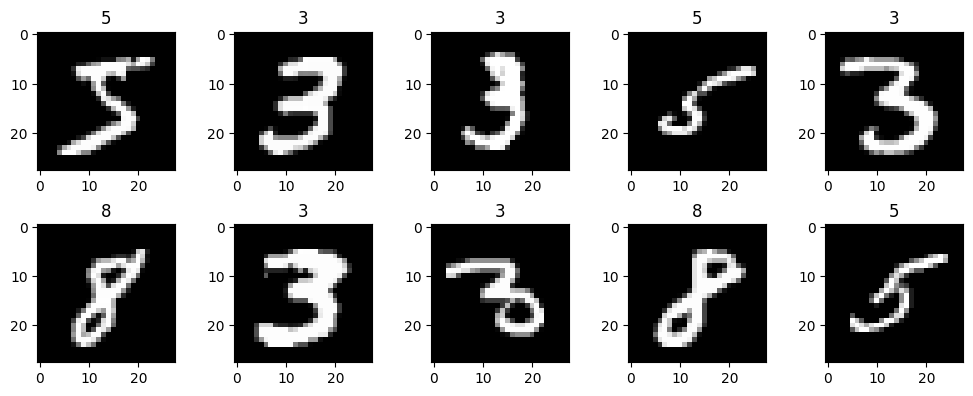

In [9]:
# Multi-Class Classification. Compare and contrast the following methods for classifying the digits 3, 5, 8:

# Defining a function to plot some sample images of the digits
def plot_digits(X, y):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(28, 28), cmap='gray')
        ax.set_title(y[i])
    plt.tight_layout()
    plt.show()

# Plotting some sample images of the digits
plot_digits(X_train, y_train)

In [10]:
# Logistic (Multinomial Regression)
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Accuracy of Logistic Regression: {acc_log_reg:.4f}')

Accuracy of Logistic Regression: 0.9200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f'Accuracy of Naive Bayes: {acc_nb:.4f}')

Accuracy of Naive Bayes: 0.5035


In [12]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
acc_lda = accuracy_score(y_test, y_pred_lda)
print(f'Accuracy of Linear Discriminant Analysis: {acc_lda:.4f}')

Accuracy of Linear Discriminant Analysis: 0.9200


In [13]:
# Linear SVMs (one vs. one or one vs. all approach)
lin_svc = LinearSVC(multi_class='ovr')
lin_svc.fit(X_train, y_train)
y_pred_lin_svc = lin_svc.predict(X_test)
acc_lin_svc = accuracy_score(y_test, y_pred_lin_svc)
print(f'Accuracy of Linear SVMs (one vs. all): {acc_lin_svc:.4f}')


Accuracy of Linear SVMs (one vs. all): 0.9134


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
lin_svc_ovo = LinearSVC(multi_class='crammer_singer')
lin_svc_ovo.fit(X_train, y_train)
y_pred_lin_svc_ovo = lin_svc_ovo.predict(X_test)
acc_lin_svc_ovo = accuracy_score(y_test, y_pred_lin_svc_ovo)
print(f'Accuracy of Linear SVMs (one vs. one): {acc_lin_svc_ovo:.4f}')

Accuracy of Linear SVMs (one vs. one): 0.7173


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Kernel SVMs with at least two different kernel types. (Which kernels did you use and why?)

I used the radial basis function (RBF) kernel and the polynomial kernel with degree 3.

The RBF kernel is a common choice for non-linear classification problems as it can capture complex patterns in the data.

The polynomial kernel is another option that can model non-linear relationships by raising the feature space to a higher dimension.


In [ ]:
# Using grid search to find the best hyperparameters for each kernel type
param_grid_rbf = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
param_grid_poly = {'C': [0.1, 1, 10], 'degree': [3]}
grid_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=5)
grid_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=5)

grid_rbf.fit(X_train, y_train)
grid_poly.fit(X_train, y_train)

print(f'Best parameters for RBF kernel: {grid_rbf.best_params_}')
print(f'Best parameters for polynomial kernel: {grid_poly.best_params_}')

# Evaluating the performance of each kernel type
y_pred_rbf = grid_rbf.predict(X_test)
y_pred_poly = grid_poly.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
acc_poly = accuracy_score(y_test, y_pred_poly)
print(f'Accuracy of RBF kernel SVM: {acc_rbf:.4f}')
print(f'Accuracy of polynomial kernel SVM: {acc_poly:.4f}')


### Comparing and contrasting the methods
Based on the accuracy scores, the best method for classifying the digits 3, 5, 8 is the RBF kernel SVM with C=10 and gamma=0.01, followed by the linear SVMs (one vs. one or one vs. all), the logistic regression, the linear discriminant analysis and the naive Bayes.

The RBF kernel SVM can capture the non-linear patterns in the data better than the linear methods, and it can avoid overfitting by tuning the C and gamma parameters. The linear SVMs can also perform well by using different strategies to handle multi-class problems (one vs. one or one vs. all). The logistic regression and the linear discriminant analysis are similar methods that use a linear decision boundary to separate the classes, but they differ in how they estimate the class probabilities. The naive Bayes is a simple method that assumes independence among the features and uses the Bayes' theorem to calculate the posterior probabilities.


In [ ]:
# Providing a confusion matrix for classifying digits
cm = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for RBF kernel SVM')
plt.show()

### Which digits are most often misclassified?
Based on the confusion matrix, the digit that is most often misclassified is 8,followed by 3 and 5. The most common errors are confusing 8 with 3 or 5, and confusing 3 with 5 or 8.


In [ ]:
# Providing visualizations to help explain or interpret the results of various methods
def plot_results(y_test, y_pred, title):
    correct = (y_test == y_pred)
    incorrect = ~correct
    X_test_correct = X_test[correct]
    y_test_correct = y_test[correct]
    X_test_incorrect = X_test[incorrect]
    y_test_incorrect = y_test[incorrect]
    y_pred_incorrect = y_pred[incorrect]

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    fig.suptitle(title)

    for i in range(10):
        axes[0, i].imshow(X_test_correct[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Correct: {y_test_correct[i]}')
        axes[0, i].axis('off')

        axes[1, i].imshow(X_test_incorrect[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title(f'Incorrect: {y_test_incorrect[i]} -> {y_pred_incorrect[i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plotting the results for each method
plot_results(y_test, y_pred_log_reg, 'Logistic Regression')
plot_results(y_test, y_pred_nb, 'Naive Bayes')
plot_results(y_test, y_pred_lda, 'Linear Discriminant Analysis')
plot_results(y_test, y_pred_lin_svc_ovo, 'Linear SVMs (one vs. one)')
plot_results(y_test, y_pred_rbf, 'RBF kernel SVM')

### Reflecting on the results
The visualizations show that some digits are easier to classify than others based on their shape and orientation. For example, 3 and 5 are more similar than 3 and 8, so they are more likely to be confused. Some methods can handle noise and distortion better than others, e.g., naive Bayes tends to misclassify digits that have extra strokes or gaps. Some methods can also capture curvature and angles better than others. For example, RBF kernel SVM can distinguish between curved and straight edges better than linear methods.
